# The Monte Carlo Method



The Monte Carlo method is a versatile tool for approximating a variety of different problems. The basic idea is to generate a large number of random samples for your problem, then for each sample we test it to see if it fits some criteria. This allows us to quickly come up with approximations based on statistical methods instead of mathematics of the problem. This can be very helpful when exploring new problems before developing a theory to explain said problem. It is also used in some cases where mathematical solutions are impossible, impractical, or unknown. In this notebook, we will look at two very different problems and craft simulations to approximate the solution. The problems shown in these examples are fairly easy to solve using traditional mathematics. As such, we will also quickly look at the true solution to the problem so that we can get some sense of how accurate our simulations are. I will go into some of the mathematics required to solve these problems, however the focus of this notebook is on the Monte Carlo method, so do not worry if you can not quite follow the true solution. Instead focus on understanding the problem definition, and the code used to simulate the problem. 




For our first example, let's say you play a lot of poker, you might be interested in finding out exactly how likely you are to get a certain poker hand. For this example, let's say you wanted to know the probability that a random five card hand would contain a four of a kind.  
We will start by defining a function to deal us a random hand of five cards. This function will return a list of strings where each string is the name of an individual card. the output will look like this  
`['Ace of spades', '7 of hearts', '7 of spades', '7 of clubs', '7 of diamonds']`  

In [1]:
# install the deck of cards library from pip 
%pip install deck_of_cards 

You should consider upgrading via the '/home/kid/.virtualenvs/jup/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from deck_of_cards import deck_of_cards
from scipy.special import comb

# create a global deck 
obj = deck_of_cards.DeckOfCards()

def random_hand(hand_size=5): 
    obj.shuffle_deck() # this is our source of random values
    d = [x.name for x in obj.deck] # this is a list comprehension that creates an ordered list equivalent to the current order of the deck 
    return d[:hand_size] # use python list slice to return the first 5 cards 



Now that we have our random hand function defined, we will create a simple for loop to call our function many times. Each time we will check if the given hand contains a four of a kind. Since we are only interested in four of a kind, let's remove the suit information from the data, converting it to something like this  
`['Ace', '7', '7', '7', '7']`  
From here, we can check if any of the members of this list are present exactly 4 times in the list. If true, then we have a four of a kind we increment our total variable. After that all that is left to do is start the process all over again with a new random hand.

In [3]:
%%time
games=300000 # this defines how many times we run the simulation
total = 0 # this is our counter we will increment every time we see the expected result
for _ in range(games): 
    hand = random_hand() # get a new random hand of 5 cards
    card_value = [] # this will collect all the card values in the current hand
    for card in hand: 
        card_value.append(card.split(" ")[0]) # split the string on the space character then take the first word (the card vale) and add it to our card_value list
    for card in card_value:
        if card_value.count(card) == 4: # here we test if the card value is present in the current hand exactly four times
            total +=1 #increment counter
            break # break out of the card_value for loop here to avoid counting this hand more than once. 

approximate_probability = total/games
print('approximate probability = ' ,approximate_probability)


approximate probability =  0.00024
CPU times: user 7.4 s, sys: 260 ms, total: 7.66 s
Wall time: 7.4 s


For this particular problem, we can verify the results of our simulation with a little math. Since we are interested in a probability, all we need to do is count the number of ways to draw a four of a kind, and divide that by the number of distinct 5 card hands that are possible from a deck of 52 cards. The numerator is fairly easy to reason out. There are 13 different ways to draw a four of a kind, one for each of the different values of a card. Then with 4 cards already drawn there are 48 other cards that could fill the 5th card slot. This means the total number of distinct 4 of a kind poker hands is `13*48`. Next, we need to figure out how many ways there are to choose 5 cards from a set of 52 cards. For this we can make use of the binomial coefficient, written as ${n \choose k}$ this can be read as `n` choose `k`. This means that given `n` cards how many ways are there to chose `k` cards. So for our purpose ${52 \choose 5}$ will tell us exactly how many ways there are to choose 5 cards from a set of 52 cards. This means we can compute the probability of drawing a four of a kind hand with the following formula  

$$\frac{48 \cdot 13}{{52 \choose 5}}$$

In [4]:
%%time

number_of_ways_to_draw_a_four_of_a_kind= 48*13
number_of_distinct_five_card_hands = comb(52,5,exact=True)
exact_probability = number_of_ways_to_draw_a_four_of_a_kind/number_of_distinct_five_card_hands
print('exact probability',exact_probability)
print('absolute difference between exact and approximate',abs(approximate_probability- exact_probability))
print("relative error" , (approximate_probability- exact_probability)/ approximate_probability)


exact probability 0.00024009603841536616
absolute difference between exact and approximate 9.603841536615088e-08
relative error -0.00040016006402562865
CPU times: user 312 µs, sys: 21 µs, total: 333 µs
Wall time: 251 µs


For our next example let's now jump to a different problem all together. In calculus, we are often interested in calculating the area under a given curve. This is generally done using integration. However there remain some curves where an integration based approach is unknown or even impossible. These situations are exactly where Monte Carlo shines! However for simplicity this example will focus on a well known curve. The definite integral shown below is really asking the following: for the curve $sin(x)$, what is the area of the space under the curve from $0$ to $\pi$

$$\int_{0}^{\pi} sin(x) \,dx$$

lets start by plotting the function $sin(x)$ from $0$ to $\pi$

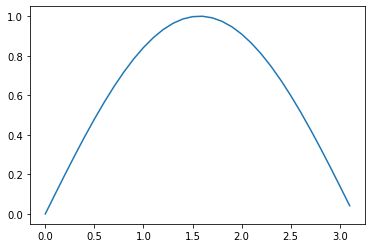

In [5]:

import matplotlib.pyplot as plt
import numpy as np
import random 
x = np.arange(0,np.pi,0.1)   # start,stop,step
y = np.sin(x)
plt.plot(x,y)




To solve this problem using the Monte Carlo method, we first construct a box containing the curve in question. By looking at the graph above, we can see that a box $1$ unit tall and $\pi$ units wide will contain the curve. Next we will generate a series of random `x,y` coordinates, for each one we will test if the point is below the curve or above it. Once we have a good approximation for the ratio of points above curve to points generated in our bounding box, we simply need to multiply that ratio by the area of the box we created. This will give us an approximation of the area under the curve. 

In [6]:
%time
sims=2000 # this defines how many times we run the simulation
count_under=0 # this is our counter we will increment every time we see the expected result
#these are used later on in the visualization of the result
points_under_x=[] 
points_under_y=[]
points_over_x=[] 
points_over_y=[]

for _ in range(sims):
#    using a bounding box 1 unit tall (y) and pi units long (x)
    x=random.random()*np.pi # random.random() returns a random number between 0 and 1. Multiplying by pi gets us a random decimal value between 0 and pi
    y=random.random() # the y dimension of our box ends at 1 so be do not need to multiply the output of random.random()
    y_actual = np.sin(x) # get the actual y value of the sin function that corresponds to the random x coordinate generated 
    if y <= y_actual: #test if our random y coordinate is on or under the curve
        count_under+=1 #increment counter
        points_under_x.append(x)
        points_under_y.append(y)
    else:
        points_over_x.append(x)
        points_over_y.append(y)
approximate_value = (count_under / sims) * np.pi # where pi is the total area of my bounding box
print( "approximate value = ",approximate_value)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 3.34 µs
approximate value =  2.0121900946242626


The correct answer to this question is $2$. as you can see we got fairly close even with a small amount of simulations. Look at the graph in the next cell. In it, orange dots mark the points above the curve while blue dots mark the points below the curve. to understand why this works it is important to realize that we are not getting to this value by measuring the area with a bunch of tiny dots. instead we are looking at the probability that a random point falls under the curve. for example, if that probability ended up being a 50/50 chance, then it would be fair to say that the area under the curve takes up half the area of the bounding box.  


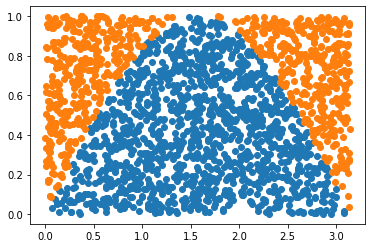

In [7]:
plt.scatter(points_under_x,points_under_y)
plt.scatter(points_over_x,points_over_y)

### exact answer

We can also solve this problem with calculus. First recall the anti derivative for $sin(x)$ is $-cos(x)$. Next we substitute in the limits of our definite integral $0$ and $\pi$ as follows.
$$(-cos(\pi)) - (- cos(0)) =2 $$

In [8]:
%time
exact_value = (-np.cos(np.pi)) - (- np.cos(0))
print("exact value" , exact_value)

print('absolute difference between exact and approximate',abs(approximate_value - exact_value))
print("relative error" , (approximate_value- exact_value)/ approximate_value)



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs
exact value 2.0
absolute difference between exact and approximate 0.01219009462426257
relative error 0.0060581227672422445


## conclusion

in this notebook we looked at 2 very different problems and wrote code to approximate a solution. The key is to look at the things these two problems share. In both we found a way to represent the problem in terms of probability question. the skill with using this method often comes from being able to translate your problem into a question of probability. 

it should be fairly obvious that this method is going to be more computationally expensive to use. Just looking at the time output in these examples shows huge gaps in performance. It is important to keep in mind that all the code in this notebook currently runs on a single thread however, most Monte Carlo code is very easy to convert to run in parallel. this can mean for some problems that do not have an easily parallelized solutions, the Monte Carlo method can be faster overall due to its ability to fully take advantage of the massively parallel hardware like GPUs. 




## questions for further exploration. 

this notebook is intended to be run modified and rerun. consider exploring some of these questions on your own. 

* how large can you make the x value in the area under the curve example? at what point does the answer start to diverge? 
* in the poker example how could you modify the code to for 7 card hands instead of 5 card? what would you change to test for a royal flush? 
* try playing with the number of simulations in each example. try rerunning this notebook multiple times with the same values. How do things change? 
* consider re working one of the examples to execute in parallel using the threads on your cpu

In [9]:
## 